In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [8]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [9]:
import os

In [17]:
path="archive/data"
vehicles_path=os.path.join(path,"vehicles")
non_vehicles_path=os.path.join(path,"non-vehicles")

labels=[]
images=[]

for vehicle in os.listdir(vehicles_path):
    labels.append("vehicle")
    images.append(plt.imread(os.path.join(vehicles_path,vehicle)))
    
for non_vehicle in os.listdir(non_vehicles_path):
    labels.append("non_vehicle")
    images.append(plt.imread(os.path.join(non_vehicles_path,non_vehicle)))
    
data_df=pd.DataFrame({"image":images,"label":labels})

In [18]:
data_df

,image,label
0,"[[[0.13333334, 0.14117648, 0.16470589], [0.129...",vehicle
1,"[[[0.28627452, 0.30980393, 0.36078432], [0.278...",vehicle
2,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",vehicle
3,"[[[0.15686275, 0.15686275, 0.105882354], [0.17...",vehicle
4,"[[[0.27058825, 0.35686275, 0.43529412], [0.137...",vehicle
...,...,...
17755,"[[[0.21568628, 0.24705882, 0.20392157], [0.207...",non_vehicle
17756,"[[[0.25882354, 0.25882354, 0.21960784], [0.243...",non_vehicle
17757,"[[[0.22352941, 0.24705882, 0.19215687], [0.219...",non_vehicle
17758,"[[[0.25490198, 0.28235295, 0.22745098], [0.250...",non_vehicle


Text(0.5, 1.0, 'Data repartition')

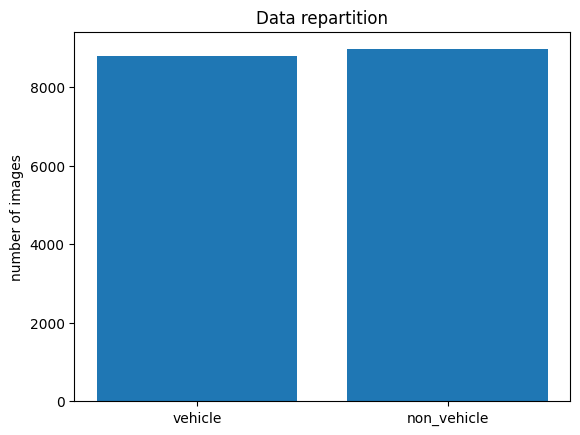

In [19]:
number_of_vehicle=len(data_df.loc[data_df["label"]=="vehicle"])
number_of_non_vehicle=len(data_df.loc[data_df["label"]=="non_vehicle"])
plt.bar(["vehicle","non_vehicle"],[number_of_vehicle,number_of_non_vehicle])
plt.ylabel('number of images')
plt.title("Data repartition")

Text(0.5, 0.98, 'Data sample')

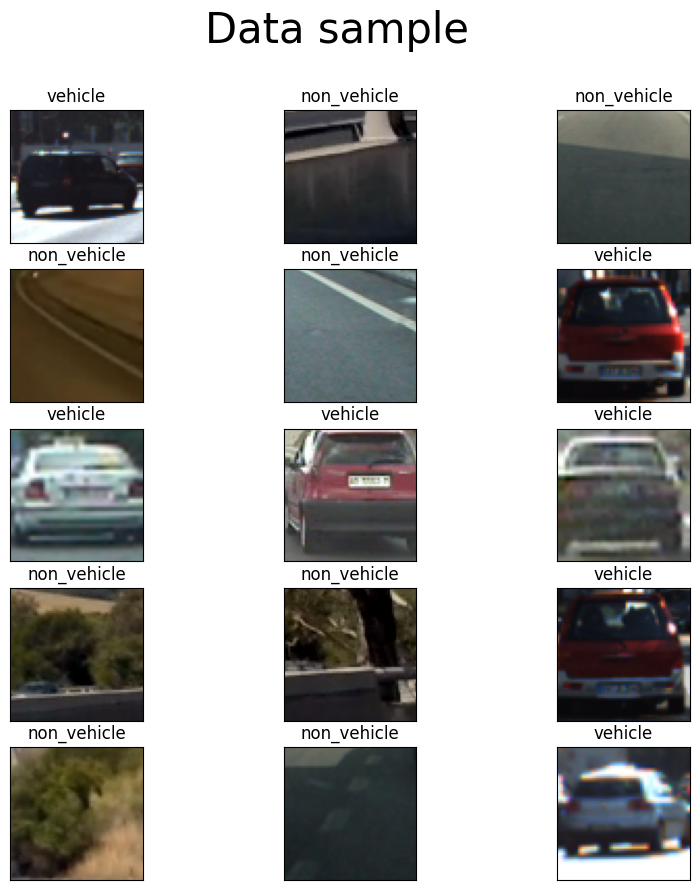

In [20]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})
plot_images= random.choices(np.arange(len(data_df)),k=15)
for i,ax in enumerate(axes.flat):
    ax.imshow(data_df["image"][plot_images[i]])
    ax.set_title(data_df["label"][plot_images[i]])
fig.suptitle("Data sample",fontsize=30)

In [21]:
data_df["img_shape"]=data_df["image"].apply(lambda x : x.shape)

In [22]:
data_df["img_shape"].loc[data_df["img_shape"]!=data_df.iloc[0]["img_shape"]]

Series([], Name: img_shape, dtype: object)

In [23]:
data_df=data_df.drop(["img_shape"],axis=1)

In [24]:
train_df,test_df=train_test_split(data_df,test_size=0.2,random_state=42)

Text(0.5, 1.0, 'train/test data repartition')

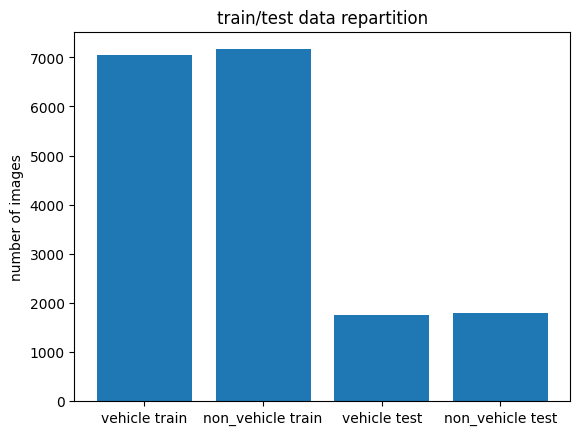

In [25]:
number_of_vehicle_training=len(train_df.loc[train_df["label"]=="vehicle"])
number_of_non_vehicle_training=len(train_df.loc[train_df["label"]=="non_vehicle"])

number_of_vehicle_testing=len(test_df.loc[test_df["label"]=="vehicle"])
number_of_non_vehicle_testing=len(test_df.loc[test_df["label"]=="non_vehicle"])


plt.bar(["vehicle train","non_vehicle train","vehicle test","non_vehicle test"],[number_of_vehicle_training,number_of_non_vehicle_training,
                                                                                number_of_vehicle_testing,number_of_non_vehicle_testing])
plt.ylabel('number of images')
plt.title("train/test data repartition")

In [26]:
class ImageDataset(Dataset):
    def __init__(self,df,device):
        super().__init__()
        self.df=df
        self.device=device
    def __len__(self):
        return len(self.df)
    def __getitem__(self,x):
        image=torch.tensor(self.df.iloc[x]["image"],dtype=torch.float32,device=self.device).permute(2,0,1)
        label= torch.tensor(1 if self.df.iloc[x]["label"]=="vehicle" else 0,dtype=torch.long,device=self.device)
        return image,label
    
train_dataset=ImageDataset(train_df,device)
test_dataset=ImageDataset(test_df,device)

batch_size=32

train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=True)        

In [27]:
class conv_net(nn.Module):
    def __init__(self,nb_channels,classes,img_size=64):
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=nb_channels,out_channels=20,kernel_size=(3,3),padding=1)
        self.r1=nn.ReLU()
        self.pool1=nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        
        self.conv2=nn.Conv2d(in_channels=20,out_channels=50,kernel_size=(3,3),padding=1)
        self.r2=nn.ReLU()
        self.pool2=nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
    
        self.l1=nn.Linear(in_features=int((img_size/4)*(img_size/4)*50),out_features=500)
        self.r3=nn.ReLU()
        self.l2 = nn.Linear(in_features=500, out_features=classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)
    def forward(self,x):
        
        out=self.conv1(x)
        out=self.r1(out)
        out=self.pool1(out)
        
        
        out=self.conv2(out)
        out=self.r2(out)
        out=self.pool2(out)
        
        #print(out.shape)
        out=torch.flatten(out,1)
        out=self.l1(out)
        out=self.r3(out)
        
        #print(out.shape)
        out=self.l2(out)
        out=self.logSoftmax(out)
        return out

In [28]:
model=conv_net(3,2)
model.to(device)

conv_net(
  (conv1): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (r1): ReLU()
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (r2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (l1): Linear(in_features=12800, out_features=500, bias=True)
  (r3): ReLU()
  (l2): Linear(in_features=500, out_features=2, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
)

In [29]:
epochs=20
lr=0.001
loss=nn.CrossEntropyLoss()
optim=torch.optim.Adam(model.parameters(),lr=lr)

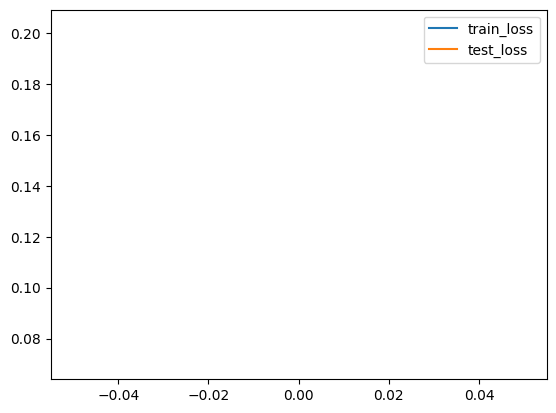

train_loss : 0.202504904229647  | test_loss : 0.07064326845847808
train_loss : 0.05664344878394266  | test_loss : 0.03566812612703658
train_loss : 0.04061760047114001  | test_loss : 0.026409898826911173


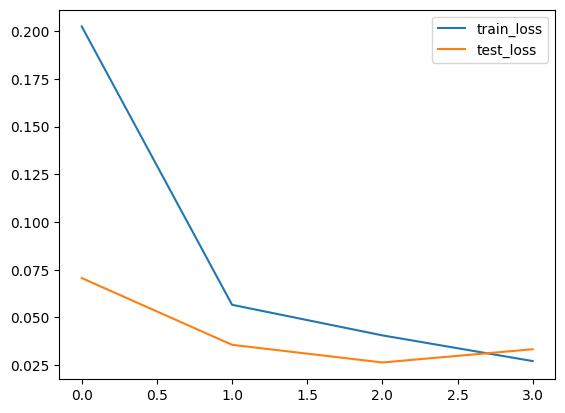

train_loss : 0.027143859537514997  | test_loss : 0.03333659879737408
train_loss : 0.02066729838056212  | test_loss : 0.02110134833072824
train_loss : 0.01762108848431724  | test_loss : 0.04321398318699049


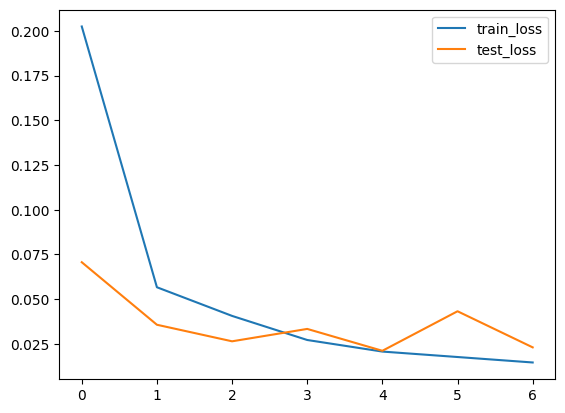

train_loss : 0.014566921781618287  | test_loss : 0.023022089511951064
train_loss : 0.011647090097482703  | test_loss : 0.04314212198480639
train_loss : 0.00821536986221143  | test_loss : 0.021646771664027172


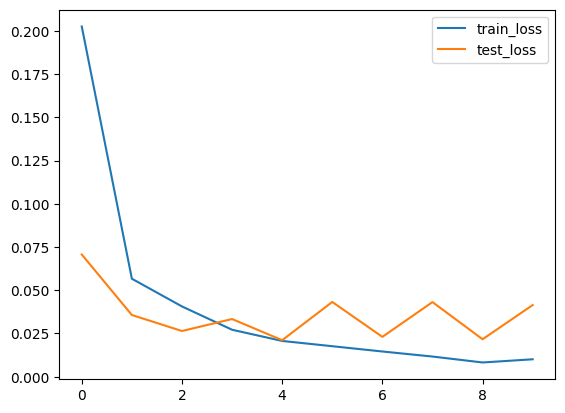

train_loss : 0.010060050668503639  | test_loss : 0.04143195786512864


KeyboardInterrupt: 

In [30]:
plot_freq=3
save_train=[]
save_test=[]

for epoch in range(epochs) :
    model.train()
    avg_train_loss=0
    avg_test_loss=0
    it_train=0
    it_test=0
    for images,label in train_loader :
        predictions=model(images)
        l=loss(predictions,label)
        optim.zero_grad()
        l.backward()
        optim.step()
        avg_train_loss+=l.item()
        it_train+=1
    model.eval()
    for images,label in test_loader:
        predictions=model(images)
        l=loss(predictions,label)
        avg_test_loss+=l.item()
        it_test+=1
    save_train.append(avg_train_loss/it_train)
    save_test.append(avg_test_loss/it_test)
    if epoch%plot_freq==0 :
        x=np.arange(0,len(save_train))
        plt.plot(x,save_train,label='train_loss')
        plt.plot(x,save_test,label="test_loss")
        plt.legend()
        plt.show()
    print("train_loss :",avg_train_loss/it_train," | test_loss :",avg_test_loss/it_test)        

In [31]:
acc=0
model.eval()
ytrue=[]
ypred=[]
for image,label in test_dataset :
    pred=int(torch.argmax(model(image.unsqueeze(0))))
    ytrue.append(label.item())
    ypred.append(pred)
    acc+=1 if pred==label.item() else 0
print("accuracy :",acc/len(test_dataset))

accuracy : 0.9822635135135135


Text(0.5, 1.0, 'Confusion matrix for the test set')

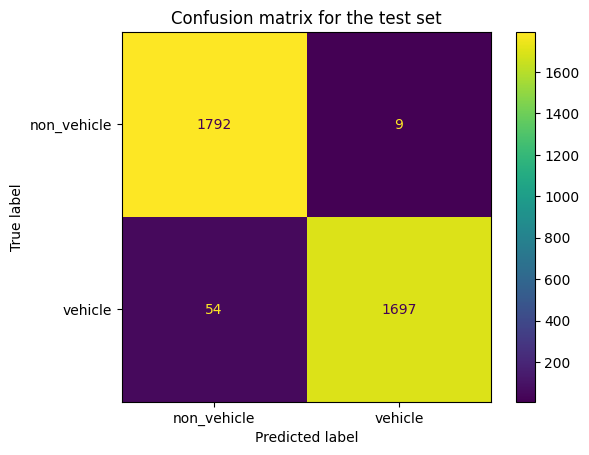

In [32]:
ConfusionMatrixDisplay(confusion_matrix(ytrue,ypred),display_labels=['non_vehicle',"vehicle"]).plot()
plt.title("Confusion matrix for the test set")

In [33]:
torch.save(model.state_dict(), "models/convnet2.pth")

RuntimeError: Parent directory models does not exist.

In [34]:
false_images=[]
false_labels=[]
for i,(image,_) in enumerate(test_dataset) :
    if ytrue[i]!=ypred[i]:
        false_images.append(image.cpu().permute(1,2,0).numpy())
        false_labels.append("vehicle" if ypred[i] else "non_vehicle")
        

IndexError: list index out of range

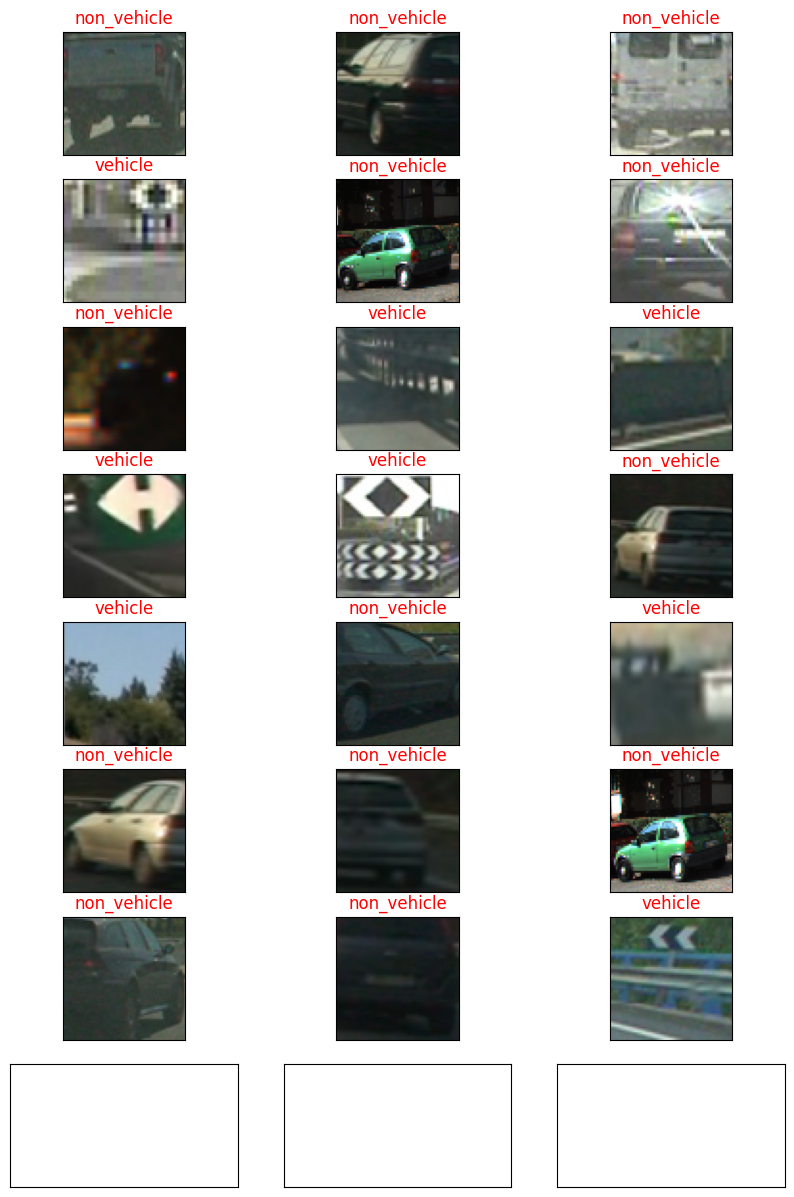

In [26]:
fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(10, 15),
                        subplot_kw={'xticks': [], 'yticks': []})
for i,ax in enumerate(axes.flat):
    ax.imshow(false_images[i])
    ax.set_title(false_labels[i],color="r")
fig.suptitle("Errors in classification",fontsize=30)

In [35]:
false_label

NameError: name 'false_label' is not defined